### Installing required libraries


In [1]:
 # !pip install numpy
 # !pip install pandas
 # !pip install matplotlib
 # !pip install seaborn
 # !pip install pillow
 # !pip install torch
 # !pip install torchvision
 # !pip install scikit-learn

### Importing required libraries


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
#constants and configuration
device="cuda" if  torch.cuda.is_available() else "cpu"

In [4]:
train_dir="mri_dataset/Training" # training directory
test_dir="mri_dataset/testing" # testing directory

categories=sorted(os.listdir(train_dir))
batch_size=64; #64

label_map={"glioma":0,
            "meninggioma":1,
            "notumor":2,
           "pituitary":3
          }

class_dict={v: k for k, v in label_map.items()}

In [6]:
def count_images_per_class(directory):
    
    count={} # empty dictionary
    for name in os.listdir(directory):
        path=directory + "/" + name
        if os.path.isdir(path):
            count[name]=len(os.listdir(path))
    return count

print("Training distionary:",count_images_per_class("mri_dataset/training"))
print("Testing distionary:",count_images_per_class("mri_dataset/testing"))


def show_pie_chart(count,title):

    labels=list(count.keys())
    sizes=list(count.values())
    plt.figure()
    plt.pie(sizes,labels=labels,autopct='%1.1f%%')
 
    plt.title(title)
    plt.show()

def plot_image_grid(images,titles=None,cols=3,figsize=None,cmap='gray'):



    n=len(images)
    rows=(n+cols-1)//cols

    if figsize is None: 
        figsize=(cols*4,rows*4)

    fig,axes=plt.subplots(rows,cols,figsize=figsize)
    axes=np.array(axes).reshape(-1)
    
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i<n: 
            img=images[i]
            ax.imshow(img,cmap=cmap)
            if titles:
                ax.set_title(titles[i],fontsize=10)

    plt.tight_layout()
    plt.show()

def show_sample_images(directory,n):


    class_dirs=[]
    for d in os.listdir(directory):
        if os.path.isdir(os.path.join(directory,d)):
            class_dirs.append(d)

    samples=[]
    while len(samples) < n:
        cls=random.choice(class_dirs)
        files=os.listdir(os.path.join(directory,cls))
        fname=random.choice(files)
        samples.append((cls, os.path.join(directory,cls,fname)))


    images,titles = [],[]
    for cls ,path in samples:
        img = plt.imread(path)
        h,w = img.shape[:2]
        ch = img.shape[2] if img.ndim==3 else 1
        images.append(img)
        titles.append(f"{cls}\n{os.path.basename(path)}\n"
                      f"{h}x{w}px, ch={ch}")
    plot_image_grid(images,titles,cols=3)  

def show_tensor_batch(images,labels,class_names,cols=4):
    titles=[f"label:{class_names[int(lb1)]}" for lb1 in labels]
    plot_image_grid(images,titles,cols=cols)

def show_data_distribution(datasets_dir):
    global_counts={}
    for dataset in os.listdir(datasets_dir):
        dataset_path=datasets_dir+"/"+dataset
        count=count_images_per_class(dataset_path)
        show_pie_chart(count,f"Images per class in {dataset}")
        global_counts[dataset]=sum(count.values())
    show_pie_chart(global_counts, "Total images: Training vs Testing")


 

Training distionary: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing distionary: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


Data distribution


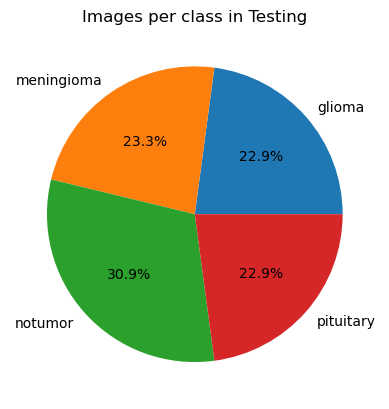

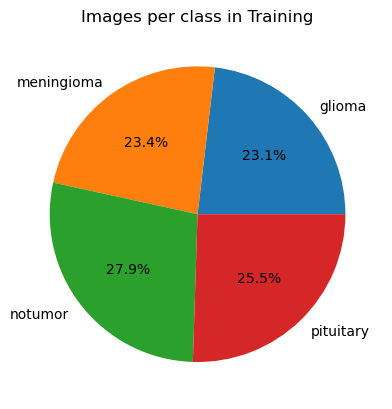

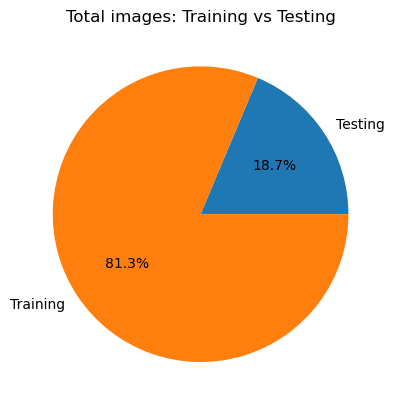

In [7]:
 print("Data distribution")
 show_data_distribution("mri_dataset")
 

Training sample images



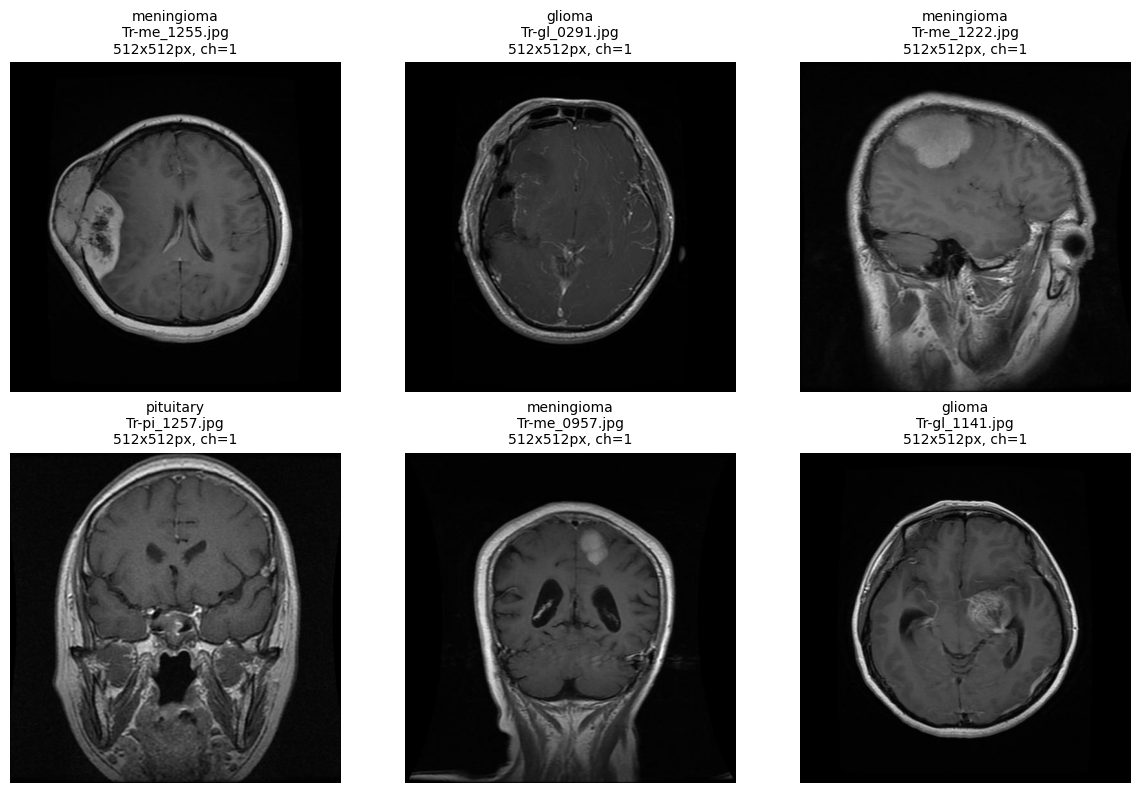


Testing sample images



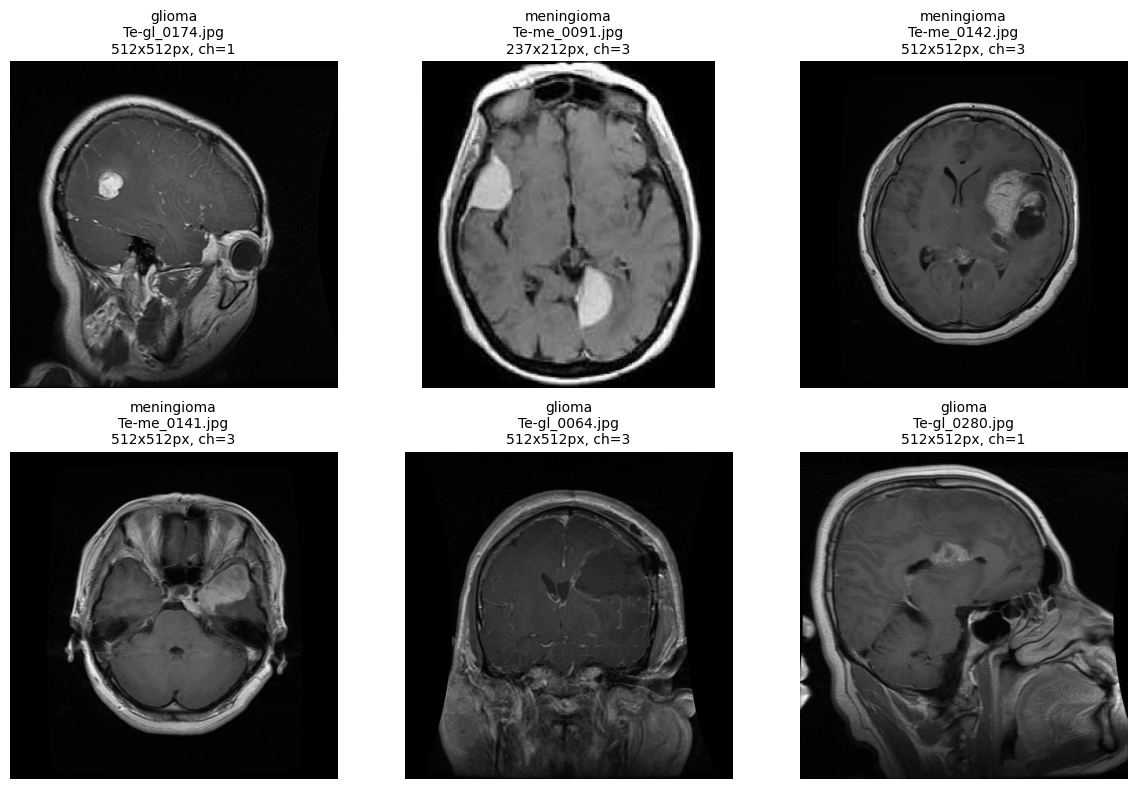

In [8]:
print("Training sample images\n")
show_sample_images(train_dir,n=6)
print("\nTesting sample images\n")
show_sample_images(test_dir,n=6)


In [9]:
simple_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
  ])


dataset=ImageFolder(train_dir,transform=simple_transform)

loader=DataLoader(dataset,batch_size=batch_size,shuffle=False)

mean=0.0
variance=0.0
total_images=0

for images, _ in loader:
    B,C,H,W=images.shape  # B = batch size, C=no. of channels, H=height, W= width
    images=images.view(B,C ,-1)
    batch_mean=images.mean(dim=2).sum(dim=0)
    batch_var=images.var(dim=2).sum(dim=0)
    mean+=batch_mean
    variance+=batch_var
    total_images+=B


mean/=total_images
std=(variance/total_images).sqrt()

print(mean,variance,std)


mean=np.array(mean.tolist())
std=np.array(std.tolist())

print(mean,std)

tensor([0.1855]) tensor([201.8196]) tensor([0.1880])
[0.18545197] [0.1879696]


In [11]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=(0.8,1.2)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])              

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])


all_train_datasets=ImageFolder(train_dir,transform=train_transform)

targets=np.array([label for _, label in all_train_datasets])

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state = 42)

for train_idx, val_idx in split.split(np.zeros(len(targets)),targets):
    train_dataset=Subset(all_train_datasets,train_idx)
    val_dataset= Subset(all_train_datasets,val_idx)

test_dataset=ImageFolder(test_dir,transform=test_transform)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

                               


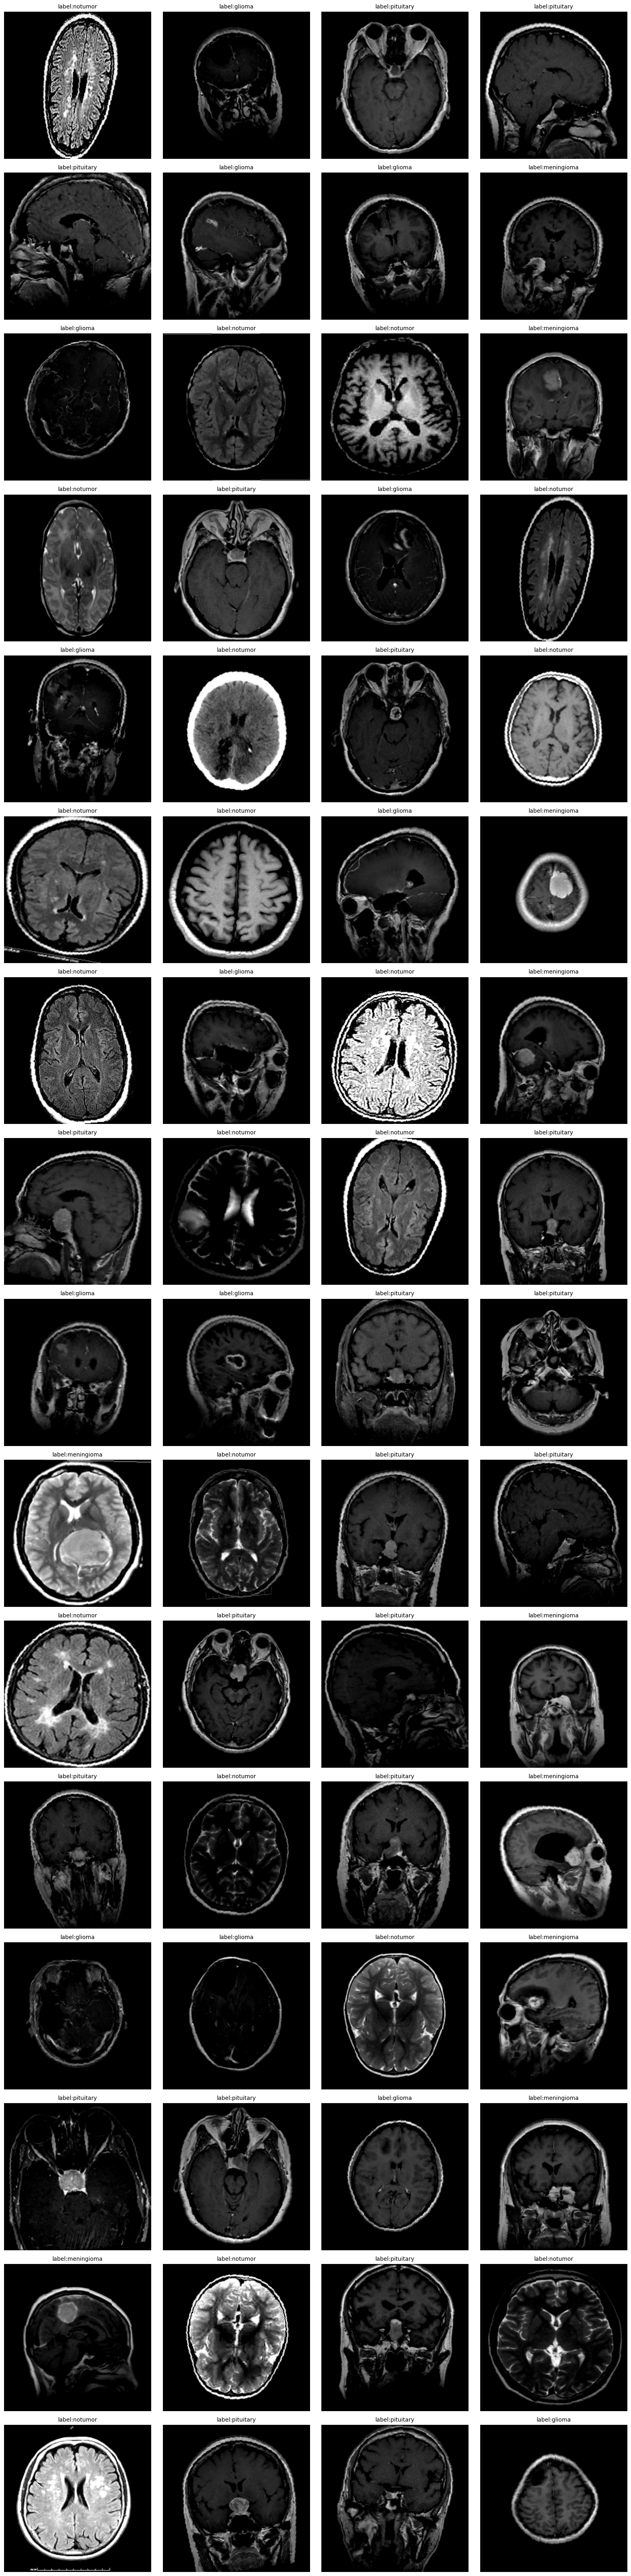

In [12]:
data_iter = iter(train_loader)
images, labels= next(data_iter)
images=(images.numpy().transpose((0,2,3,1)) * std * mean).clip(0,1)
show_tensor_batch(images,labels,categories,cols=4)


In [16]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier,self).__init__()
        self.features = nn.Sequential(
        #C x H x W
        #1 X 224 X 224
            nn.Conv2d(1,32, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        #32 X 112 X 112 
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        #64 X 56 X 56
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        # 128 X 28 X 28    
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        #256 X 14 X 14
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        #256 X 7 X 7
        )

        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256 * 7 * 7 ,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,num_classes)
 )


    def forward(self,x):
        feat=self.features(x)
        out=self.fc(feat)
        return out
        

            
         

In [17]:

#print(train_loader,"       ",test_loader,val_loader)

<torch.utils.data.dataloader.DataLoader object at 0x0000024BDC565BB0>         <torch.utils.data.dataloader.DataLoader object at 0x0000024BDC273230> <torch.utils.data.dataloader.DataLoader object at 0x0000024BDC591BB0>


In [18]:
model = BrainTumorClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0007)


In [58]:
def train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs,name="model", patience=7):
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    best_val_loss=float("inf")
    tolerance=0
    history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    for epoch in range(num_epochs):
        #Training stage
        model.train()
        running_loss=0.0
        correct_train=0
        total_train=0

        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            _, predicted=torch.max(outputs,1)
            total_train+=labels.size(0)
            correct_train+=(predicted == labels).sum().item()


        train_loss=running_loss/len(train_loader)
        train_acc=100*correct_train/ total_train

        #Validation stage
        model.eval()
        val_loss=0.0
        correct_val=0
        total_val=0
        with torch.no_grad():
            for images,labels in val_loader: 
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _, predicted= torch.max(outputs,1)
                total_val+=labels.size(0)
                correct_val+=(predicted==labels).sum().item()

        val_loss=val_loss / len(val_loader)
        val_acc=100*correct_val/total_val


        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss:{train_loss:.4f} | train accuracy:{train_acc:.3f}%")
        print(f"Val Loss:{val_loss:.4f} | Val Accuracy:{val_acc:.3f}%")
        print("-"*50)


        if val_loss<best_val_loss:
            best_val_loss= val_loss
            torch.save(model.state_dict(),f'best_brain_tumor_{name}.pth')
            tolerance=0

        
        else:
            tolerance+=1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history
    

In [59]:
print("start training........")
history=train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs=2)


start training........

Epoch [1/2]
Train Loss:0.1315 | train accuracy:95.645%
Val Loss:0.1445 | Val Accuracy:95.626%
--------------------------------------------------

Epoch [2/2]
Train Loss:0.0903 | train accuracy:97.089%
Val Loss:0.1641 | Val Accuracy:95.713%
--------------------------------------------------


In [60]:
def plot_training_history(history,model_name="model"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'],label='Train Loss')
    plt.plot(history['val_loss'],label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"],label="Train Acc")
    plt.plot(history["val_acc"],label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()
    

Graph View:


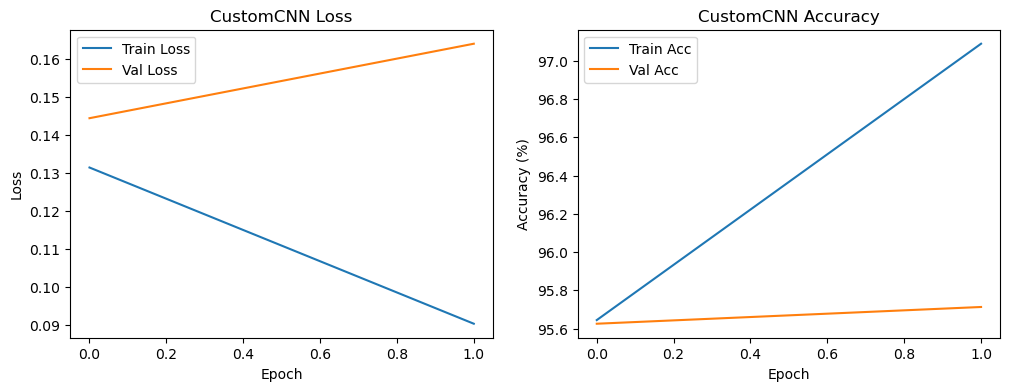

In [61]:
print("Graph View:")
plot_training_history(history,model_name="CustomCNN")

In [62]:
def plot_confusion_matrix(cm,categories):
    plt.figure(figsize=(8,4))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True label')
    plt.show()
    

In [63]:
def compute_confusion_details(cm,categories):
    TP=np.diag(cm)            #True positive
    FP=cm.sum(axis=0) - TP    #False Positive
    FN=cm.sum(axis=1) - TP    #False Negative
    TN=cm.sum() - (FP + FN + TP)

    print("\n" + "="*50)
    print("        Per-class Metrices(TP, TN, FP, FN:")
    print("="*50)
    print(f"{'class':<15} {'TP':>6} {'TN':>6} {'FP':>6} {'FN':>6}")
    print("-"*50)


    for i , cls in enumerate(categories):
        print("{:<15} {:>6} {:>6} {:>6}" .format('Class', 'TP', 'TN', 'FP', 'FN'))
    

In [64]:
def test_model(model,test_loader,num_images_to_show=10):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct=0
    total=0

    all_preds=[]
    all_labels=[]
    all_images=[]


    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()


                # save for further analysis

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())



    test_acc=100*correct/total
    print("\n" + "="*50)
    print(f"          Test Accuracy:{test_acc:.2f}%")
    print("="*50+"\n")


    cm=confusion_matrix(all_labels,all_preds)
    plot_confusion_matrix(cm,categories)
    compute_confusion_details(cm,categories)

    #print classification report
    print("\n" + "="*50)
    print("        Classification Report")
    print("="*55)
    print(classification_report(all_labels,all_preds,target_names=categories))
    



          Test Accuracy:94.05%



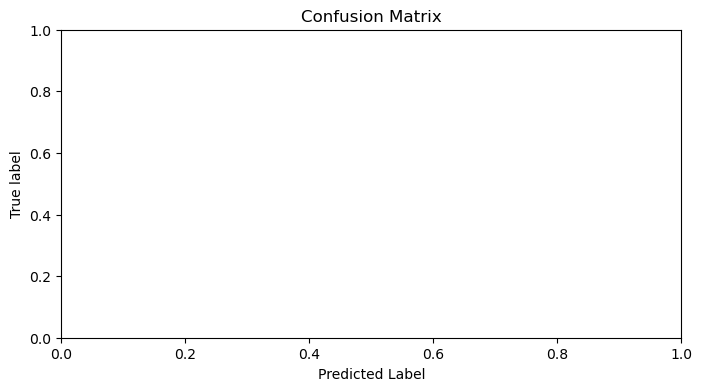


        Per-class Metrices(TP, TN, FP, FN:
class               TP     TN     FP     FN
--------------------------------------------------
Class               TP     TN     FP
Class               TP     TN     FP
Class               TP     TN     FP
Class               TP     TN     FP

        Classification Report
              precision    recall  f1-score   support

      glioma       0.99      0.87      0.92       300
  meningioma       0.86      0.89      0.88       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [65]:
model.load_state_dict(torch.load("best_brain_tumor_model.pth"))
test_model(model,test_loader)

In [81]:
def plot_model_predictions(model,data_loader,num_samples):

    model.to(device).eval()
    correct_imgs=[]
    incorrect_imgs=[]
    correct_lbls=[]
    incorrect_lbls=[]
    correct_preds=[]
    incorrect_preds=[]

    with torch.no_grad():
        for data in data_loader:
            imgs,lbls=data
            imgs,lbls=imgs.to(device),lbls.to(device)
            predictions=model(imgs)
            _,predicted_classes=torch.max(predictions,1)
            for idx in range(len(predicted_classes)):
                img=imgs[idx].cpu().numpy()
                img=(img * std + mean).clip(0,1)
                img=np.squeeze(img)
                if predicted_classes[idx] == lbls[idx]:
                    correct_imgs.append(img)
                    correct_lbls.append(lbls[idx].cpu() .numpy())
                    correct_preds.append(predicted_classes[idx].cpu().numpy())

                else:
                    incorrect_imgs.append(img)
                    incorrect_lbls.append(lbls[idx].cpu().numpy())
                    incorrect_preds.append(predicted_classes[idx].cpu().numpy())


            if len(correct_imgs)>=num_samples and len(incorrect_imgs) >=num_samples:
                break

    correct_imgs=np.array(correct_imgs)
    incorrect_imgs=np.array(incorrect_imgs)


    print("\nCorrect predictions:\n")
    titles=[f"TRUE: {class_dict[lbl.item()]},PREDICTION: {class_dict[pred.item()]}" for lbl, pred in zip(correct_lbls,correct_preds)]
    plot_image_grid(correct_imgs[ :num_samples],titles,cols=3)


    print("\nIncorrect predictions:\n")
    titles=[f"TRUE: {class_dict[lbl.item()]}, PREDICTION: {class_dict[pred.item()]}" for lbl, pred in zip(incorrect_lbls,incorrect_preds)]
    plot_image_grid(incorrect_imgs[ :num_samples],titles,cols=3)

        
                    
    


Correct predictions:



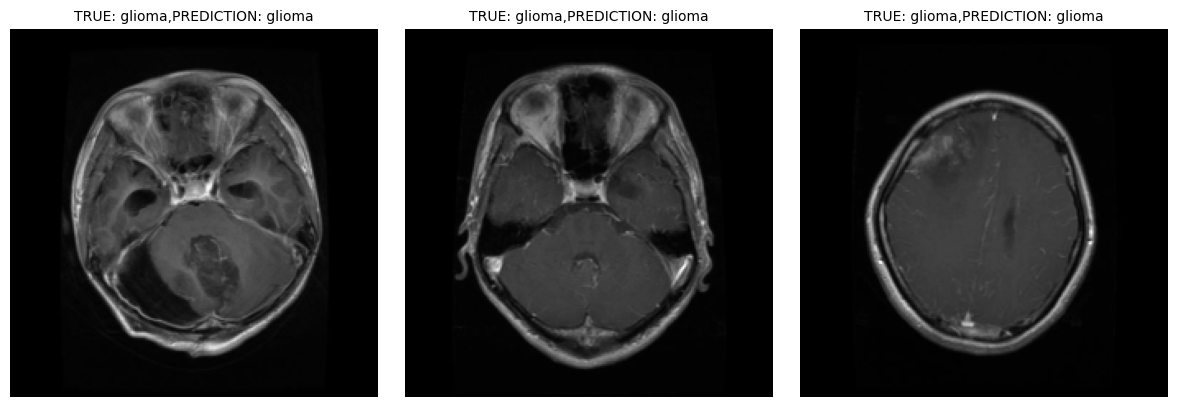


Incorrect predictions:



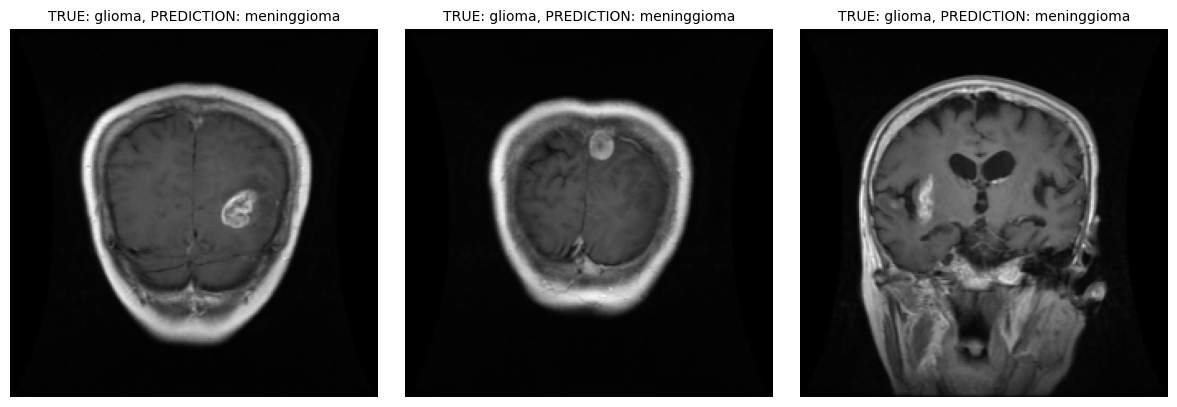

In [82]:
plot_model_predictions(model,test_loader,3)